# cuSpatial Python User's Guide

cuSpatial is a GPU-accelerated Python library for spatial data analysis including distance and  
trajectory computations, spatial data indexing and spatial join operations. cuSpatial's  
Python API provides an accessible interface to high-performance spatial algorithms accelerated
by CUDA-enabled GPUs.

## Contents

This guide provides a working example for all of the python API components of cuSpatial.  
The following list links to each subsection.

* [Installing cuSpatial](#Installing-cuSpatial)
* [GPU accelerated memory layout](#GPU-accelerated-memory-layout)
* [Input / Output](#Input-/-Output)
* [Geopandas and cuDF integration](#Geopandas-and-cuDF-integration)
* [Trajectories](#Trajectories)
* [Bounding](#Bounding)
* [Projection](#Projection)
* [Distance](#Distance)
* [Filtering](#Filtering)
* [Spatial joins](#Spatial-joins)

## Installing cuSpatial
Read the [RAPIDS Quickstart Guide](  https://rapids.ai/start.html     ) to learn more about installing all RAPIDS libraries, including cuSpatial.

If you are working on a system with a CUDA-enabled GPU and have CUDA installed, uncomment the  
following cell and install cuSpatial:

In [ ]:
# !conda create -n rapids-25.04 -c rapidsai -c conda-forge -c nvidia \ 
#     cuspatial=25.04 python=3.9 cudatoolkit=11.5 

For other options to create a RAPIDS environment, such as docker or build from source, see  
[RAPIDS Release Selector](  https://rapids.ai/start.html#get-rapids). 

If you wish to contribute to cuSpatial, you should create a source build using the excellent [rapids-compose](https://github.com/trxcllnt/rapids-compose)

## GPU accelerated memory layout

cuSpatial uses `GeoArrow` buffers, a GPU-friendly data format for geometric data that is well  
suited for massively parallel programming. See [I/O]((#Input-/-Output) on the fastest methods to get your  
data into cuSpatial. GeoArrow extends [PyArrow](
https://arrow.apache.org/docs/python/index.html       ) bindings and introduces several new types suited  
for geometry applications.  GeoArrow supports [ListArrays](
https://arrow.apache.org/docs/python/data.html#arrays) for `Points`, `MultiPoints`,  
`LineStrings`, `MultiLineStrings`, `Polygons`, and `MultiPolygons`. Using an Arrow [DenseArray](
https://arrow.apache.org/docs/python/data.html#union-arrays),  
GeoArrow stores heterogeneous types of Features. DataFrames of geometry objects and their  
metadata can be loaded and transformed in a method similar to those in [GeoPandas.GeoSeries](
https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.html).

In [1]:
# Imports used throughout this notebook.
import cuspatial
import cudf
import cupy
import geopandas
import os
import pandas as pd
import numpy as np
from shapely.geometry import *
from shapely import wkt

In [2]:
# For deterministic result
np.random.seed(0)
cupy.random.seed(0)

## Input / Output

The primary method of loading features into cuSpatial is using [cuspatial.from_geopandas](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/io.html?highlight=from_geopandas#cuspatial.from_geopandas).

One can also create feature geometries directly using any Python buffer that supports  
`__array_interface__` for coordinates and their feature offsets.

### [cuspatial.from_geopandas](https://docs.rapids.ai/api/cuspatial/stable/api_docs/io.html?highlight=from_geopandas#cuspatial.from_geopandas)

The easiest way to get data into cuSpatial is via `cuspatial.from_geopandas`.

In [3]:
host_dataframe = geopandas.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')
host_dataframe = host_dataframe.set_crs(4326)
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
print(gpu_dataframe.head())

        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_TR     FCLASS_ID     FCLASS_PL 

## Geopandas and cuDF integration

A cuSpatial [GeoDataFrame](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/geopandas_compatibility.html#cuspatial.GeoDataFrame               ) is a collection of [cudf](
https://docs.rapids.ai/api/cudf/stable/              ) [Series](
https://docs.rapids.ai/api/cudf/stable/api_docs/series.html    ) and
[cuspatial.GeoSeries](
https://docs.rapids.ai/api/cuspatial/stable/api_docs/geopandas_compatibility.html#cuspatial.GeoSeries             ) `"geometry"` objects.  
Both types of series are stored on the GPU, and
`GeoSeries` is represented internally using `GeoArrow` data layout.

One of the most important features of cuSpatial is that it is highly integrated with `cuDF`.  
You can use any `cuDF` operation on cuSpatial non-feature columns, and most operations will work  
with a `geometry` column. Operations that reduce or collate the number of rows in your DataFrame,  
for example `groupby`, are not supported at this time.

In [4]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
continents_dataframe = gpu_dataframe.sort_values("NAME")
print(continents_dataframe.head())

          featurecla  scalerank  LABELRANK   SOVEREIGNT SOV_A3  ADM0_DIF  \
103  Admin-0 country          1          3  Afghanistan    AFG         0   
125  Admin-0 country          1          6      Albania    ALB         0   
82   Admin-0 country          1          3      Algeria    DZA         0   
74   Admin-0 country          1          3       Angola    AGO         0   
159  Admin-0 country          1          4   Antarctica    ATA         0   

     LEVEL               TYPE TLC        ADMIN  ... FCLASS_TR  FCLASS_ID  \
103      2  Sovereign country   1  Afghanistan  ...      None       None   
125      2  Sovereign country   1      Albania  ...      None       None   
82       2  Sovereign country   1      Algeria  ...      None       None   
74       2  Sovereign country   1       Angola  ...      None       None   
159      2      Indeterminate   1   Antarctica  ...      None       None   

    FCLASS_PL FCLASS_GR  FCLASS_IT FCLASS_NL FCLASS_SE  FCLASS_BD FCLASS_UA  \
103    

You can also convert between GPU-backed `cuspatial.GeoDataFrame` and CPU-backed  
`geopandas.GeoDataFrame` with `from_geopandas`  and `to_geopandas`, enabling you to  
take advantage of any native GeoPandas operation. Note, however, that GeoPandas runs on  
 the CPU and therefore will not have as high performance as cuSpatial operations. The following  
example displays the `Polygon` associated with the first item in the dataframe sorted  
alphabetically by name.

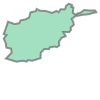

In [5]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
sorted_dataframe = gpu_dataframe.sort_values("NAME")
sorted_dataframe = sorted_dataframe.to_geopandas()
sorted_dataframe['geometry'].iloc[0]

## Trajectories

A trajectory is a `LineString` coupled with a time sample for each point in the `LineString`.  
Use  `cuspatial.trajectory.derive_trajectories` to group trajectory datasets and sort by time.

<img src="../_static/trajectory.png" width=250>

### [cuspatial.derive_trajectories](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.derive_trajectories)

In [6]:
# 1m random trajectory samples
ids = cupy.random.randint(1, 400, 1000000)
timestamps = cupy.random.random(1000000)*1000000
xy= cupy.random.random(2000000)
trajs = cuspatial.GeoSeries.from_points_xy(xy)
sorted_trajectories, trajectory_offsets = \
    cuspatial.core.trajectory.derive_trajectories(ids, trajs, timestamps)
# sorted_trajectories is a DataFrame containing all trajectory samples
# sorted first by `object_id` and then by `timestamp`.
print(sorted_trajectories.head())
# trajectory_offsets is a Series containing the start position of each
# trajectory in sorted_trajectories.
print(trajectory_offsets)

   object_id         x         y               timestamp
0          1  0.680146  0.874341 1970-01-01 00:00:00.125
1          1  0.843522  0.044402 1970-01-01 00:00:00.834
2          1  0.837039  0.351025 1970-01-01 00:00:01.335
3          1  0.946184  0.479038 1970-01-01 00:00:01.791
4          1  0.117322  0.182117 1970-01-01 00:00:02.474
0           0
1        2455
2        4899
3        7422
4        9924
        ...  
394    987408
395    989891
396    992428
397    994975
398    997448
Length: 399, dtype: int32


`derive_trajectories` sorts the trajectories by `object_id`, then `timestamp`, and returns a  
tuple containing the sorted trajectory data frame in the first index position and the offsets  
buffer defining the start and stop of each trajectory in the second index position.  

### [cuspatial.trajectory_distances_and_speeds](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.trajectory_distances_and_speeds)

Use `trajectory_distance_and_speed` to calculate the overall distance travelled in meters and  
the speed of a set of trajectories with the same format as the result returned by `derive_trajectories`.

In [7]:
trajs = cuspatial.GeoSeries.from_points_xy(
    sorted_trajectories[["x", "y"]].interleave_columns()
)
d_and_s = cuspatial.core.trajectory.trajectory_distances_and_speeds(
  len(cudf.Series(ids).unique()),
  sorted_trajectories['object_id'],
  trajs,
  sorted_trajectories['timestamp']
)
print(d_and_s.head())

                   distance        speed
trajectory_id                           
0              1.278996e+06  1280.320089
1              1.267179e+06  1268.370390
2              1.294437e+06  1295.905261
3              1.323413e+06  1323.956714
4              1.309590e+06  1311.561012


Finally, compute the bounding boxes of trajectories that follow the format of the above two  
examples:

## Bounding

Compute the bounding boxes of `n` polygons or linestrings:

<img src="../_static/bounding.png" width=250>

### [cuspatial.trajectory_bounding_boxes](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.trajectory_bounding_boxes)

`trajectory_bounding_boxes` works out of the box with the values returned by `derive_trajectories`.  
Its arguments are the number of incoming objects, the offsets of those objects, and x and y point buffers.

In [7]:
bounding_boxes = cuspatial.core.trajectory.trajectory_bounding_boxes(
  len(cudf.Series(ids, dtype="int32").unique()),
  sorted_trajectories['object_id'],
  trajs
)
print(bounding_boxes.head())

      x_min     y_min     x_max     y_max
0  0.000361  0.000170  0.999582  0.999485
1  0.000184  0.000647  0.999939  0.999884
2  0.000461  0.001395  0.999938  0.999297
3  0.000093  0.000073  0.999819  0.999544
4  0.000105  0.000112  0.999952  0.999013


### [cuspatial.polygon_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.polygon_bounding_boxes)

`polygon_bounding_boxes` supports more complex geometry objects such as `Polygon`s with multiple  
rings. The combination of `part_offset` and `ring_offset` allows the function to use only the  
exterior ring for computing the bounding box.

In [8]:
single_polygons = cuspatial.from_geopandas(
    host_dataframe['geometry'][host_dataframe['geometry'].type == "Polygon"]
)
bounding_box_polygons = cuspatial.core.spatial.bounding.polygon_bounding_boxes(
    single_polygons
)
print(bounding_box_polygons.head())

        minx       miny       maxx       maxy
0  29.339998 -11.720938  40.316590  -0.950000
1 -17.063423  20.999752  -8.665124  27.656426
2  46.466446  40.662325  87.359970  55.385250
3  55.928917  37.144994  73.055417  45.586804
4  12.182337 -13.257227  31.174149   5.256088


### [cuspatial.linestring_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.linestring_bounding_boxes)

Equivalently, we can treat trajectories as Linestrings and compute the same bounding boxes from  
the above trajectory calculation more generally:

In [9]:
lines = cuspatial.GeoSeries.from_linestrings_xy(
    trajs.points.xy, trajectory_offsets, cupy.arange(len(trajectory_offsets))
)
trajectory_bounding_boxes = cuspatial.core.spatial.bounding.linestring_bounding_boxes(
    lines, 0.0001
)
print(trajectory_bounding_boxes.head())

       minx      miny      maxx      maxy
0  0.000261  0.000070  0.999682  0.999585
1  0.000084  0.000547  1.000039  0.999984
2  0.000361  0.001295  1.000038  0.999397
3 -0.000007 -0.000027  0.999919  0.999644
4  0.000005  0.000012  1.000052  0.999113


## Projection

cuSpatial provides a simple sinusoidal longitude / latitude to Cartesian coordinate transform.  
This function requires an origin point to determine the scaling parameters for the lonlat inputs.  

### [cuspatial.sinusoidal_projection](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.sinusoidal_projection)

The following cell converts the lonlat coordinates of the country of Afghanistan to Cartesian  
coordinates in km, centered around the center of the country, suitable for graphing and display.

In [10]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
afghanistan = gpu_dataframe['geometry'][gpu_dataframe['NAME'] == 'Afghanistan']
points = cuspatial.GeoSeries.from_points_xy(afghanistan.polygons.xy)
projected = cuspatial.sinusoidal_projection(
    afghanistan.polygons.x.mean(),
    afghanistan.polygons.y.mean(),
    points
)
print(projected.head())

0     POINT (112.174 -281.59)
1     POINT (62.152 -280.852)
2     POINT (-5.573 -257.391)
3    POINT (-33.071 -243.849)
4     POINT (-98.002 -279.54)
dtype: geometry


## Distance
cuSpatial provides a growing suite of distance computation functions. Parallel distance functions  
come in two main forms: pairwise, which computes a distance for each corresponding pair of input  
geometries; and all-pairs, which computes a distance for the each element of the Cartesian product  
of input geometries (for each input geometry in A, compute the distance from A to each input
geometry in B)."
    
Two pairwise distance functions are included in cuSpatial: `haversine` and `pairwise_linestring`.  
The `hausdorff` clustering distances algorithm is also available, computing the hausdorff  
distance across the cartesian product of its single input.

### [cuspatial.directed_hausdorff_distance](https://docs.rapids.ai/api/cuspatial/stable/api_docs/trajectory.html#cuspatial.directed_hausdorff_distance)

The directed Hausdorff distance from one space to another is the greatest of all the distances  
between any point in the first space to the closet point in the second. This is especially useful  
as a similarity metric between trajectories.

<img src="../_static/hausdorff.png" width=250>

[Hausdorff distance](https://en.wikipedia.org/wiki/Hausdorff_distance)

In [11]:
coordinates = sorted_trajectories[['x', 'y']].interleave_columns()
spaces = cuspatial.GeoSeries.from_multipoints_xy(
    coordinates, trajectory_offsets
)
hausdorff_distances = cuspatial.core.spatial.distance.directed_hausdorff_distance(
    spaces
)
print(hausdorff_distances.head())

        0         1         2         3         4         5         6    \
0  0.000000  0.034755  0.031989  0.031959  0.031873  0.038674  0.029961   
1  0.030328  0.000000  0.038672  0.032086  0.031049  0.032170  0.032275   
2  0.027640  0.030539  0.000000  0.036737  0.033055  0.043447  0.028812   
3  0.031497  0.033380  0.035224  0.000000  0.032581  0.035484  0.030339   
4  0.031079  0.032256  0.035731  0.039084  0.000000  0.036416  0.031369   

        7         8         9    ...       388       389       390       391  \
0  0.029117  0.040962  0.033259  ...  0.031614  0.036447  0.035548  0.028233   
1  0.030215  0.034443  0.032998  ...  0.030594  0.035665  0.031473  0.031916   
2  0.031807  0.039269  0.033250  ...  0.031998  0.033636  0.034646  0.032615   
3  0.034792  0.045755  0.031810  ...  0.033623  0.031359  0.034923  0.032287   
4  0.030388  0.033751  0.034029  ...  0.030705  0.040339  0.034328  0.029027   

        392       393       394       395       396       397  
0  0

### [cuspatial.haversine_distance](https://docs.rapids.ai/api/cuspatial/stable/api_docs/gis.html#cuspatial.haversine_distance)

Haversine distance is the great circle distance between longitude and latitude pairs. cuSpatial  
uses the `lon/lat` ordering to better reflect the cartesian coordinates of great circle  
coordinates: `x/y`.

<img src="../_static/haversine.png" width=250>

In [12]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
polygons_first = gpu_dataframe['geometry'][0:10]
polygons_second = gpu_dataframe['geometry'][10:30]

points_first = polygons_first.polygons.xy[0:1000]
points_second = polygons_second.polygons.xy[0:1000]

first = cuspatial.GeoSeries.from_points_xy(points_first)
second = cuspatial.GeoSeries.from_points_xy(points_second)

# The number of coordinates in two sets of polygons vary, so
# we'll just compare the first set of 1000 values here.
distances_in_meters = cuspatial.haversine_distance(
    first, second
)
cudf.Series(distances_in_meters).head()

0    9959.695143
1    9803.166859
2    9876.857085
3    9925.097106
4    9927.268486
Name: None, dtype: float64

This above method reads the GeoPandas data from CPU memory into GPU memory and then cuSpatial processes it. If the data is already in a cuDF GPU dataframe, you can quickly calculate Haversine distances using the method below. This maximizes speed by keeping all the processing on the GPU and is very useful when working on large datasets.

In [13]:
# Generate data to be used to create a cuDF dataframe.  
# The data to be processed by Haversine MUST be a Float.
a = {"latitude":[17.1167, 17.1333, 25.333, 25.255, 24.433, 24.262, 35.317, 34.21, 34.566, 31.5, 36.7167, 30.5667, 28.05, 22.8, 35.7297, 36.97, 36.78, 36.8, 36.8, 36.72],
     "longitude": [-61.7833, -61.7833, 55.517, 55.364, 54.651, 55.609, 69.017, 62.228, 69.212, 65.85, 3.25, 2.8667, 9.6331, 5.4331, 0.65, 7.79, 3.07, 3.03, 3.04, 4.05]}
df = cudf.DataFrame(data=a)

# Create cuSpatial GeoSeries from cuDF Dataframe
cuGeoSeries = cuspatial.GeoSeries.from_points_xy(df[['longitude', 'latitude']].interleave_columns())

# Create Comparator cuSpatial GeoSeries from a comparator point
df['atlanta_lat'] = 33.7490
df['atlanta_lng'] = -84.3880
atlGeoSeries = cuspatial.GeoSeries.from_points_xy(df[['atlanta_lat', 'atlanta_lng']].interleave_columns())

# Calculate Haversine Distance of cuDF dataframe to comparator point
df['atlanta_dist'] = cuspatial.haversine_distance(cuGeoSeries, atlGeoSeries)
print(df.head())

   latitude  longitude  atlanta_lat  atlanta_lng  atlanta_dist
0   17.1167   -61.7833       33.749      -84.388  11961.556540
1   17.1333   -61.7833       33.749      -84.388  11963.392729
2   25.3330    55.5170       33.749      -84.388  12243.126130
3   25.2550    55.3640       33.749      -84.388  12233.867463
4   24.4330    54.6510       33.749      -84.388  12139.822218


### Pairwise distance

`pairwise_linestring_distance` computes the distance between a `GeoSeries` of Linestrings of  
length `n` and a corresponding `GeoSeries` of Linestrings of `n` length. It returns the  
minimum distance from any point in the first linestring of the pair to the nearest segment  
or point within the second Linestring of the pair.

The input accepts a pair of geoseries as input sequences of linestring arrays.

The below example uses the polygons from `naturalearth_lowres` and treats them as linestrings.  
The first example computes the distances between all polygons and themselves, while the second  
example computes the distance between the first 50 polygons and the second 50 polygons.

### [cuspatial.pairwise_linestring_distance](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.pairwise_linestring_distance)

In [14]:
gpu_boundaries = cuspatial.from_geopandas(host_dataframe.geometry.boundary)
zeros = cuspatial.pairwise_linestring_distance(
    gpu_boundaries[0:50],
    gpu_boundaries[0:50]
)
print(zeros.head())
lines1 = gpu_boundaries[0:50]
lines2 = gpu_boundaries[50:100]
distances = cuspatial.pairwise_linestring_distance(
    lines1, lines2
)
print(distances.head())

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
dtype: float64
0    152.200610
1     44.076445
2      2.417269
3     44.197151
4     75.821029
dtype: float64


`pairwise_point_linestring_distance` computes the distance between pairs of points and  
linestrings. It can be used with polygons treated as linestrings as well. In the following  
example the minimum distance from a country's center to it's border is computed.

### [cuspatial.pairwise_point_linestring_distance](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.pairwise_point_linestring_distance)

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [15]:
# Convert input dataframe to Pseudo-Mercator projection.
host_dataframe3857 = host_dataframe.to_crs(3857)
polygons = host_dataframe3857[host_dataframe3857['geometry'].type == "Polygon"]
gpu_polygons = cuspatial.from_geopandas(polygons)
# Extract mean_x and mean_y from each country
mean_x = [gpu_polygons['geometry'].iloc[[ix]].polygons.x.mean() for ix in range(len(gpu_polygons))]
mean_y = [gpu_polygons['geometry'].iloc[[ix]].polygons.y.mean() for ix in range(len(gpu_polygons))]
# Convert mean_x/mean_y values into Points for use in API.
points = cuspatial.GeoSeries([Point(point) for point in zip(mean_x, mean_y)])
# Convert Polygons into Linestrings for use in API.
linestring_df = cuspatial.from_geopandas(geopandas.geoseries.GeoSeries(
    [MultiLineString(mapping(polygons['geometry'].iloc[ix])["coordinates"]) for ix in range(len(polygons))]
))
gpu_polygons['border_distance'] = cuspatial.pairwise_point_linestring_distance(
    points, linestring_df
)
print(gpu_polygons.head())

         featurecla  scalerank  LABELRANK                        SOVEREIGNT  \
1   Admin-0 country          1          3       United Republic of Tanzania   
2   Admin-0 country          1          7                    Western Sahara   
5   Admin-0 country          1          3                        Kazakhstan   
6   Admin-0 country          1          3                        Uzbekistan   
11  Admin-0 country          1          2  Democratic Republic of the Congo   

   SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
1     TZA         0      2  Sovereign country   1   
2     SAH         0      2      Indeterminate   1   
5     KA1         1      1        Sovereignty   1   
6     UZB         0      2  Sovereign country   1   
11    COD         0      2  Sovereign country   1   

                               ADMIN  ...     FCLASS_ID     FCLASS_PL  \
1        United Republic of Tanzania  ...          None          None   
2                     Western Sahara  ...  Unrecognized  Unr

### cuspatial.pairwise_point_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [16]:
countries = host_dataframe

cities = geopandas.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_populated_places_simple.zip')
cities = cities.to_crs(3857)

gpu_cities = cuspatial.from_geopandas(cities)
gpu_countries = cuspatial.from_geopandas(countries)
dist = cuspatial.pairwise_point_polygon_distance(
    gpu_cities.geometry[:len(gpu_countries)], gpu_countries.geometry
)

gpu_countries["distance_from"] = cities.name
gpu_countries["distance"] = dist

print(gpu_countries.head())

        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      2            Country   1     United States of America  ...   

      FCLASS_PL  FCLASS_GR FCLASS_IT     FCL

### cuspatial.pairwise_linestring_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [17]:
# all driveways within 2km range of central park, nyc

if not os.path.exists("./streets_3857.csv"):
    import osmnx as ox
    graph = ox.graph_from_point((40.769361, -73.977655), dist=2000, network_type="drive")
    nodes, streets = ox.graph_to_gdfs(graph)
    streets = streets.to_crs(3857)
    streets = streets.reset_index(drop=True)
    streets.index.name = "index"
    streets[["name", "geometry"]].to_csv("streets_3857.csv")

# The data is under notebooks/streets_3857.csv
streets = pd.read_csv("./streets_3857.csv", index_col="index")
streets.geometry = streets.geometry.apply(wkt.loads)
streets = geopandas.GeoDataFrame(streets)
streets.head()

,name,geometry
index,,
0,Columbus Avenue,"LINESTRING (-8234860.077 4980333.535, -8234863..."
1,West 80th Street,"LINESTRING (-8235173.854 4980508.442, -8235160..."
2,Amsterdam Avenue,"LINESTRING (-8235173.854 4980508.442, -8235168..."
3,West 80th Street,"LINESTRING (-8235369.475 4980617.398, -8235347..."
4,Broadway,"LINESTRING (-8235369.475 4980617.398, -8235373..."


In [19]:
# The polygon of the Empire State Building

if not os.path.exists("./esb_3857.csv"):
    import osmnx as ox
    esb = ox.features.features_from_place('Empire State Building, New York', tags={"building": True})
    esb = esb.to_crs(3857)
    esb = esb.geometry.reset_index(drop=True)
    esb.index.name = "index"
    esb.to_csv("esb_3857.csv")

# The data is under notebooks/esb_3857.csv
esb = pd.read_csv("./esb_3857.csv", index_col="index")
esb.geometry = esb.geometry.apply(wkt.loads)
esb = geopandas.GeoDataFrame(esb)
esb = pd.concat([esb.iloc[0:1]] * len(streets))
esb.head()

/raid/jlamb/miniforge/envs/cuspatial-dev/lib/python3.11/site-packages/osmnx/features.py:294: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union


,geometry
index,
0,"POLYGON ((-8236139.639 4975314.625, -8235990.3..."
0,"POLYGON ((-8236139.639 4975314.625, -8235990.3..."
0,"POLYGON ((-8236139.639 4975314.625, -8235990.3..."
0,"POLYGON ((-8236139.639 4975314.625, -8235990.3..."
0,"POLYGON ((-8236139.639 4975314.625, -8235990.3..."


In [20]:
# Straight line distance between the driveways to the Empire State Building
gpu_streets = cuspatial.from_geopandas(streets.geometry)
gpu_esb = cuspatial.from_geopandas(esb.geometry)

dist = cuspatial.pairwise_linestring_polygon_distance(gpu_streets, gpu_esb).rename("dist")
pd.concat([streets["name"].reset_index(drop=True), dist.to_pandas()], axis=1)

,name,dist
0,Columbus Avenue,4993.583717
1,West 80th Street,5103.472213
2,Amsterdam Avenue,5208.373183
3,West 80th Street,5275.851781
4,Broadway,5178.999774
...,...,...
1862,West 82nd Street,5411.762092
1863,Broadway,5476.345847
1864,West 84th Street,5613.403002
1865,West 75th Street,4750.092380


### cuspatial.pairwise_polygon_distance

Using WGS 84 Pseudo-Mercator, distances are in meters.

In [21]:
african_countries = gpu_countries[gpu_countries.CONTINENT == "Africa"].sort_values("POP_EST", ascending=False)
asian_countries = gpu_countries[gpu_countries.CONTINENT == "Asia"].sort_values("POP_EST", ascending=False)

In [22]:
# Straight line distance between the top 10 most populated countries in Asia and Africa
population_top10_africa = african_countries[:10].reset_index(drop=True)
population_top10_asia = asian_countries[:10].reset_index(drop=True)
dist = cuspatial.pairwise_polygon_distance(
    population_top10_africa.geometry, population_top10_asia.geometry)

cudf.concat([
    population_top10_africa["NAME"].rename("Africa"),
    population_top10_asia["NAME"].rename("Asia"), 
    dist.rename("dist")], axis=1
)

,Africa,Asia,dist
0,Nigeria,China,64.966620
1,Ethiopia,India,25.598868
2,Egypt,Indonesia,60.717434
3,Dem. Rep. Congo,Pakistan,37.489668
4,South Africa,Bangladesh,72.860545
5,Tanzania,Japan,97.872886
6,Kenya,Philippines,75.450451
7,Uganda,Vietnam,69.827567
8,Algeria,Turkey,17.927419
9,Sudan,Iran,13.990335


## Filtering

The filtering module contains `points_in_spatial_window`, which returns from a set of points only those points that fall within a spatial window defined by four bounding coordinates: `min_x`, `max_x`, `min_y`, and `max_y`. The following example finds only the points of polygons that fall within 1 standard deviation of the mean of all of the polygons.

<img src="../_static/spatial_window.png" width=550>

### [cuspatial.points_in_spatial_window](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.points_in_spatial_window)

In [23]:
gpu_dataframe = cuspatial.from_geopandas(host_dataframe)
geometry = gpu_dataframe['geometry']
points = cuspatial.GeoSeries.from_points_xy(geometry.polygons.xy)
mean_x, std_x = (geometry.polygons.x.mean(), geometry.polygons.x.std())
mean_y, std_y = (geometry.polygons.y.mean(), geometry.polygons.y.std())
avg_points = cuspatial.points_in_spatial_window(
    points,
    mean_x - std_x,
    mean_x + std_x,
    mean_y - std_y,
    mean_y + std_y
)
print(avg_points.head())

0       POINT (33.90371 -0.95)
1    POINT (34.07262 -1.05982)
2    POINT (37.69869 -3.09699)
3     POINT (37.7669 -3.67712)
4    POINT (39.20222 -4.67677)
dtype: geometry


With some careful grouping, one can reconstruct the original complete polygons that fall within the range.

## Set Operations

### Linestring Intersections

cuSpatial provides a linestring-linestring intersection algorithm to compute the overlapping geometries between two linestrings.
The API also returns the ids for each returned geometry to help user to trace back the source geometry.

In [24]:
from cuspatial.core.binops.intersection import pairwise_linestring_intersection

usa_boundary = cuspatial.from_geopandas(host_dataframe[host_dataframe.NAME == "United States of America"].geometry.boundary)
canada_boundary = cuspatial.from_geopandas(host_dataframe[host_dataframe.NAME == "Canada"].geometry.boundary)

list_offsets, geometries, look_back_ids = pairwise_linestring_intersection(usa_boundary, canada_boundary)

In [25]:
# The first integer series shows that the result contains 1 row (since we only have 1 pair of linestrings as input).
# This row contains 144 geometires.
list_offsets

[
  0,
  142
]
dtype: int32

In [31]:
# The second element is a geoseries that contains the intersecting geometries, with 144 rows, including points and linestrings.
geometries

0                            POINT (-130.53611 54.80275)
1                            POINT (-130.53611 54.80278)
2                            POINT (-130.53611 54.80275)
3                                 POINT (-129.98 55.285)
4                            POINT (-130.53611 54.80278)
                             ...                        
137                  LINESTRING (-120 49, -117.03121 49)
138                     LINESTRING (-122.84 49, -120 49)
139               LINESTRING (-117.03121 49, -107.05 49)
140    LINESTRING (-83.89077 46.11693, -83.61613 46.1...
141    LINESTRING (-82.69009 41.67511, -82.43928 41.6...
Length: 142, dtype: geometry

In [26]:
# The third element is a dataframe that contains IDs to the input segments and linestrings, 4 for each result row.
# Each represents ids to lhs, rhs linestring and segment ids.
look_back_ids

,lhs_linestring_id,lhs_segment_id,rhs_linestring_id,rhs_segment_id
0,"[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, ...","[18, 16, 18, 15, 17, 137, 14, 16, 13, 15, 14, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 10, 10, 11, 11, 28, 12, 12, 13, 13, 14, 15..."


## Spatial Joins

cuSpatial provides a number of functions to facilitate high-performance spatial joins, 
including unindexed and quadtree-indexed point-in-polygon and quadtree-indexed point to nearest
linestring.

The API for spatial joins does not yet match GeoPandas, but with knowledge of cuSpatial data formats
you can call  `cuspatial.point_in_polygon` for large numbers of points on 32 polygons or less, or
call `cuspatial.quadtree_point_in_polygon` for large numbers of points and polygons.  

### Unindexed Point-in-polygon Join

### [cuspatial.point_in_polygon](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.point_in_polygon)

In [27]:
single_polygons = host_dataframe[host_dataframe['geometry'].type == "Polygon"]
gpu_dataframe = cuspatial.from_geopandas(single_polygons)
x_points = (cupy.random.random(10000000) - 0.5) * 360
y_points = (cupy.random.random(10000000) - 0.5) * 180
xy = cudf.DataFrame({"x": x_points, "y": y_points}).interleave_columns()
points = cuspatial.GeoSeries.from_points_xy(xy)

short_dataframe = gpu_dataframe.iloc[0:31]
geometry = short_dataframe['geometry']

points_in_polygon = cuspatial.point_in_polygon(
    points, geometry
)
sum_of_points_in_polygons_0_to_31 = points_in_polygon.sum()
sum_of_points_in_polygons_0_to_31.head()

1     11896
2      1268
5     50835
6      7792
11    29318
dtype: int64

cuSpatial includes another join algorithm, `quadtree_point_in_polygon` that uses an indexing  
quadtree for faster calculations. `quadtree_point_in_polygon` also supports a number of  
polygons limited only by memory constraints.

### Quadtree Indexing

The indexing module is used to create a spatial quadtree. Use  
```
cuspatial.quadtree_on_points(
    points,
    x_min,
    x_max,
    y_min,
    y_max,
    scale,
    max_depth,
    max_size
)
```
to create the quadtree object that is used by the `quadtree_point_in_polygon`  
function in the `join` module.

The function uses a set of points and a user-defined bounding box to build an  
indexing quad tree. Be sure to adjust the parameters appropriately, with larger  
parameter values for larger datasets.

`scale`: A scaling function that increases the size of the point space from an  
origin defined by `{x_min, y_min}`. This can increase the likelihood of generating  
well-separated quads.

`max_depth`: In order for a quadtree to index points effectively, it must have a
depth that is log-scaled with the size of the number of points. Each level of the  
quad tree contains 4 quads. The number of available quads $q$ for indexing is then  
equal to $q = 4^{d}$ where $d$ is the `max_depth` parameter. With an input size  
of `10m` points and `max_depth = 7`, $\frac{10^6}{4^7}$ points will be most  
efficiently packed into the leaves of the quad tree.

`max_size`: The maximum number of points allowed in an internal node before it is
split into four leaf notes. As the  quadtree is generated, a leaf node containing
usable index points will be created as points are added. If the number of points
in this leaf exceeds `max_size`, the leaf will be subdivided, with four new
leaves added and the original node removed from the set of leaves. This number is
probably optimized in most datasets by making it a significant fraction of the
optimal leaf size computation from above. Consider $10,000,000 / 4^7 / 4 = 153$.

### [cuspatial.quadtree_on_points](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_on_points)

In [28]:
x_points = (cupy.random.random(10000000) - 0.5) * 360
y_points = (cupy.random.random(10000000) - 0.5) * 180
xy = cudf.DataFrame({"x": x_points, "y": y_points}).interleave_columns()
points = cuspatial.GeoSeries.from_points_xy(xy)

scale = 5
max_depth = 7
max_size = 125
point_indices, quadtree = cuspatial.quadtree_on_points(points,
                                                       x_points.min(),
                                                       x_points.max(),
                                                       y_points.min(),
                                                       y_points.max(),
                                                       scale,
                                                       max_depth,
                                                       max_size)
print(point_indices.head())
print(quadtree.head())

0     1507
1     1726
2     4242
3     7371
4    11341
dtype: uint32
   key  level  is_internal_node  length  offset
0    0      0              True       4       2
1    1      0              True       2       6
2    0      1              True       4       8
3    1      1              True       4      12
4    2      1              True       2      16


### Indexed Spatial Joins

The quadtree spatial index (`point_indices` and `quadtree`) is used by `quadtree_point_in_polygon`
and `quadtree_point_to_nearest_linestring` to accelerate larger spatial joins. 
`quadtree_point_in_polygon` depends on a number of intermediate products calculated here using the
following functions.

### [cuspatial.join_quadtree_and_bounding_boxes](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.join_quadtree_and_bounding_boxes)
### [cuspatial.quadtree_point_in_polygon](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_point_in_polygon)

In [29]:
polygons = gpu_dataframe['geometry']

poly_bboxes = cuspatial.polygon_bounding_boxes(
    polygons
)
intersections = cuspatial.join_quadtree_and_bounding_boxes(
    quadtree,
    poly_bboxes,
    polygons.polygons.x.min(),
    polygons.polygons.x.max(),
    polygons.polygons.y.min(),
    polygons.polygons.y.max(),
    scale,
    max_depth
)
polygons_and_points = cuspatial.quadtree_point_in_polygon(
    intersections,
    quadtree,
    point_indices,
    points,
    polygons
)
print(polygons_and_points.head())

Empty DataFrame
Columns: [polygon_index, point_index]
Index: []


You can see above that polygon 270 maps to the first 5 points. In order to bring this back to  
a specific row of the original dataframe, the individual polygons must be mapped back to their  
original MultiPolygon row. This is left an an exercise.

### [cuspatial.quadtree_point_to_nearest_linestring](https://docs.rapids.ai/api/cuspatial/nightly/api_docs/spatial.html#cuspatial.quadtree_point_to_nearest_linestring)

`cuspatial.quadtree_point_to_nearest_linestring` can be used to find the Polygon or Linestring  
nearest to a set of points from another set of mixed geometries. 

In [30]:
gpu_countries = cuspatial.from_geopandas(countries[countries['geometry'].type == "Polygon"])
gpu_cities = cuspatial.from_geopandas(cities[cities['geometry'].type == 'Point'])

In [31]:
polygons = gpu_countries['geometry'].polygons

boundaries = cuspatial.GeoSeries.from_linestrings_xy(
    cudf.DataFrame({"x": polygons.x, "y": polygons.y}).interleave_columns(),
    polygons.ring_offset,
    cupy.arange(len(polygons.ring_offset))
)

point_indices, quadtree = cuspatial.quadtree_on_points(gpu_cities['geometry'],
                                                       polygons.x.min(),
                                                       polygons.x.max(),
                                                       polygons.y.min(),
                                                       polygons.y.max(),
                                                       scale,
                                                       max_depth,
                                                       max_size)
poly_bboxes = cuspatial.linestring_bounding_boxes(
    boundaries,
    2.0
)
intersections = cuspatial.join_quadtree_and_bounding_boxes(
    quadtree,
    poly_bboxes,
    polygons.x.min(),
    polygons.x.max(),
    polygons.y.min(),
    polygons.y.max(),
    scale,
    max_depth
)
result = cuspatial.quadtree_point_to_nearest_linestring(
    intersections,
    quadtree,
    point_indices,
    gpu_cities['geometry'],
    boundaries
)
print(result.head())

Empty DataFrame
Columns: [point_index, linestring_index, distance]
Index: []


_Images used with permission from Wikipedia Creative Commons_